In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
df = pd.read_csv('ord_vol.csv')
df['beg_month'] = pd.to_datetime(df['beg_month'])

In [3]:
df.dtypes["ro"] in ['int64', 'datetime64[ns]']

True

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32725 entries, 0 to 32724
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  32725 non-null  int64         
 1   beg_month   32725 non-null  datetime64[ns]
 2   product     32725 non-null  object        
 3   region      32725 non-null  object        
 4   district    32725 non-null  object        
 5   terr        32725 non-null  object        
 6   ro          32725 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 1.7+ MB


In [53]:
# flake8: noqa: E501

import numpy as np
import pandas as pd
import pmdarima
import datetime
import typing
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

## Changes to be made
## 1 would like to add an argument 

class TSFM(object):
    def __init__(self,
                 df: pd.core.frame.DataFrame,
                 n_pred_period: int,
                 date_variable: typing.Union[int, str],
                 value_variable: typing.Union[int, str],
                 target_variable: str,
                 stop_date: str = None,         # stop date of train set, to split df to train and test sets
                 section_list: list = None,
                 cycle_length: int = 12,
                 do_anomaly_filter : bool = True,
                 alpha: float = 0.05,):
        self.target_variable = target_variable
        self.n_pred_period = n_pred_period
        self.stop_date = stop_date
        self.cycle_length = cycle_length
        # train and test df must have date as index, and 2 columns: sections(e.g. territory) and values(e.g. order_volume)
        if type(date_variable) is int:
            date_variable = df.columns[date_variable]
        if type(value_variable) is int:
            value_variable = df.columns[value_variable]
        # Select relevant columns for train and test df, create empty pred df
        self.columns = [date_variable, target_variable, value_variable]
        df[self.columns[0]] = pd.to_datetime(df[self.columns[0]])

        self.df = df
        self.pred = pd.DataFrame(columns=self.columns)

        # keys: sections(territories), value: list(train, test, pred), for easy storing and fetching data
        self.df_dict = dict()
        self.model_dict = dict()

        # Iterate through the unique sections
        self.section_list = section_list
        if self.section_list is None:
            self.section_list = df[target_variable].unique()
        for section in self.section_list:
            print("Inspecting", section, "...")
            # Query data for one selected section
            temp_train_df = self.get_train_data(section=section)
            if temp_train_df.shape[0] >= 2 * cycle_length:
                if do_anomaly_filter:
                    temp_train_df = self.anomaly_filter(temp_train_df, alpha=alpha)
                print("Training", temp_train_df.shape[0], "records ...")
                # set Date as Index
                # temp df now has 2 columns: section(territory) and value(order_volume)
                arima_model = pmdarima.auto_arima(temp_train_df[temp_train_df.columns[-1]],
                                                start_p=0, start_P=0,
                                                start_q=0, start_Q=0,
                                                d=1, D=1,
                                                max_p=4, max_P=2,
                                                max_d=2, max_D=2,
                                                max_q=2, max_Q=2,
                                                trace=True, m=cycle_length)
                self.model_dict[section] = arima_model
            else:
                print("Number of data points in Section", section, "is too small (" + str(
                    temp_train_df.shape[0]) + ". Must be at least twice the declared cycle length.")
    def get_actual_data(self, section: str):
            agg_df = self.df[self.columns].groupby(self.columns[0:2], as_index=False).sum()
            agg_df = agg_df.query(self.columns[1] + "==" + "'" + section + "'")[[self.columns[0], self.columns[2]]]
            agg_df.set_index(self.columns[0], inplace=True)
            agg_df = TSFM.to_monthly(agg_df)
            return agg_df

    def get_train_data(self, section: str,):  ## added stop date
        actual_df = self.get_actual_data(section)
        if self.stop_date is None:
            return actual_df
        return actual_df.iloc[lambda x: x.index <= self.stop_date]

    def get_test_data(self, section: str,):
        actual_df = self.get_actual_data(section)
        if self.stop_date is None:
            return actual_df
        return actual_df.iloc[lambda x: x.index > self.stop_date]

    

    def get_pred_data(self, section: str, return_conf_int: bool = False):
        train_df = self.get_train_data(section)
        model = self.model_dict[section]
        pred, conf_int = model.predict(self.n_pred_period, return_conf_int=return_conf_int)
            
        # date_generator = DateGenerator(start_date=max(self.train[self.columns[0]]))
        temp_pred_df = pd.DataFrame(
            data={
                self.columns[0]: pd.date_range(max(train_df.index),freq='MS',periods=self.n_pred_period+1)[1:],
                self.columns[1]: [section for x in range(len(pred))],
                self.columns[-1]: pred})  # Use numbers inplace of future dates for now)
        self.pred = self.pred.append(temp_pred_df, ignore_index=True)
        temp_pred_df = temp_pred_df[[self.columns[0], self.columns[2]]]
        temp_pred_df.set_index(self.columns[0], inplace=True)
        return temp_pred_df, conf_int

    def plot(self, section: str):
        train_df = self.get_train_data(section)
        pred_df = self.get_pred_data(section)
        fig, ax = plt.subplots(figsize=(12, 7))
        fig.suptitle("Prediction at " + self.columns[1] + " level (" + section +  ")")
        ax.set_xlabel("Periods")
        ax.set_ylabel(self.columns[-1])
        train_df.plot(ax=ax, marker='o')
        pred_df.plot(ax=ax, marker='o')
        ax.legend(["train", "prediction"])
        plt.show()
    
    def back_testing_plot(self, section: str):
        actual = self.get_actual_data(section)
        pred, ci = self.get_pred_data(section, return_conf_int=True)
        fig, ax = plt.subplots(figsize=(14,6))
        ax.plot(actual.index, actual[actual.columns[0]],label="Actual")   #Actuals This should come from original DS (all actuals)
        ax.plot(pred.index, pred[pred.columns[0]], '-r',alpha=0.75,label="Forecast")  ## Pred
        ax.fill_between(pred.index, ci[:, 0], ci[:, 1],alpha=0.3, color='b')  ## Conf intervals
        plt.title('Forecast Model')
        plt.xlabel('Year')
        plt.ylabel('Forecast Accurary')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())


        plt.legend()
        plt.show()



    def get_df(self):
        return_df = self.df
        for section in self.section_list:
            pred = pd.DataFrame.copy(self.df_dict[section][1])
            pred.reset_index(inplace=True)
            pred[self.target_variable] = [section for x in range(pred.shape[0])]
            return_df = return_df.append(pred, ignore_index=True)
        return_df.sort_values(by=[self.columns[1], self.columns[0]], inplace=True, ignore_index=True)
        return return_df

    def get_pred_df(self):
        return_df = pd.DataFrame(columns=self.columns)
        for section in self.section_list:
            pred = pd.DataFrame.copy(self.df_dict[section][1])
            pred.reset_index(inplace=True)
            pred[self.target_variable] = [section for x in range(pred.shape[0])]
            return_df = return_df.append(pred, ignore_index=True)
        return_df.sort_values(by=[self.columns[1], self.columns[0]], inplace=True, ignore_index=True)
        return return_df

    # def is_anomalous(self, section: str, actual_value: float, date: datetime.datetime):
    #     model = self.model_dict[section]
    #     future_date_index = self.df_dict[section][0].index[-1].month - date.month
    #     print("current_date = {}, pred_date = {}".format(self.df_dict[section][0].index[-1], date))
    #     print([self.df_dict[section][0].shape[0] + future_date_index - 1])
    #     pred = model.fit_predict([self.df_dict[section][0].shape[0] + future_date_index - 1])[-1]
    #     alpha = 0.05
    #     conf_int = model.conf_int(alpha = alpha)
    #     extreme_conf_int = model.conf_int(alpha = 0.0005)

    #     # zscore = (actual_value - forecast[0][-1]) / max(float(forecast[1][-1]), float_min)
    #     # anomaly_probability = (2 * st.norm(0, 1).cdf(abs(zscore))) - 1
        
    #     result = {'Prediction': float(pred) if not float(
    #                     pred) == float('inf') else 0.0,
    #                 'CILower': float(conf_int[0]) if not float(
    #                     conf_int[0]) == float('-inf') else 0.0,
    #                 'CIUpper': float(conf_int[1]) if not float(
    #                     conf_int[1]) == float('inf') else 0.0,
    #                 'ConfLevel': float(1.0 - alpha) * 100,
    #                 'IsAnomaly': actual_value < conf_int[0] or actual_value > conf_int[1],
    #                 'IsAnomalyExtreme': actual_value < extreme_conf_int[0] or actual_value > extreme_conf_int[1],}
    #                 # 'AnomalyProbability': 1 if raw_actual is None else float(anomaly_probability),
    #                 # 'DownAnomalyProbability': 1 if raw_actual is None else float(down_anomaly_probability),
    #                 # 'UpAnomalyProbability': 1 if raw_actual is None else float(up_anomaly_probability),
    #                 # 'ModelFreshness': model_freshness}
    #     print(result)
    #     return(result)
    
    def anomaly_filter(self, df: pd.core.frame.DataFrame, train_size = 24, alpha: float = 0.05):
        '''
        input df is monthly
        input df has date as index and 1 value column
        '''
        def find_anomaly_index(actual_list: list, conf_int_list: list, inf_bound: int = None):
            print("finding Anomaly Index")
            print(actual_list, conf_int_list)
            for i in range(len(actual_list)):
                actual = actual_list[i]
                conf_int =  conf_int_list[i]
                if inf_bound is not None:
                    conf_int[inf_bound] = np.inf
                if actual < conf_int[0] or actual > conf_int[1]:
                    return i
            return None

        train = df.head(train_size)
        inspecting_df = df.tail(df.shape[0] - train_size)
        
        while train.shape[0] < df.shape[0]:
            arima_model = pmdarima.auto_arima(train[train.columns[0]],
                                            start_p=0, start_P=0,
                                            start_q=0, start_Q=0,
                                            d=1, D=1,
                                            max_p=4, max_P=2,
                                            max_d=2, max_D=2,
                                            max_q=2, max_Q=2,
                                            trace=True, m=self.cycle_length)
            pred_list, conf_int_list = arima_model.predict(n_periods=df.shape[0] - train.shape[0], return_conf_int=True, alpha=alpha)
            anomaly_index = find_anomaly_index(df.iloc[train.shape[0]:][df.columns[0]], conf_int_list)
            if anomaly_index is not None:
                print("Anomaly spotted at {}".format(train.shape[0] + anomaly_index))
                if anomaly_index != 0:
                    train = train.append(df.iloc[train.shape[0]:train.shape[0] + anomaly_index])
                arima_model = pmdarima.auto_arima(train[train.columns[0]],
                                                    start_p=0, start_P=0,
                                                    start_q=0, start_Q=0,
                                                    d=1, D=1,
                                                    max_p=4, max_P=2,
                                                    max_d=2, max_D=2,
                                                    max_q=2, max_Q=2,
                                                    trace=True, m=self.cycle_length)
                pred_list, conf_int_list = arima_model.predict(n_periods=1, return_conf_int=True, alpha=alpha)
                pred, conf_int = pred_list[0], conf_int_list[0]
                actual = df.iloc[train.shape[0]][df.columns[0]]
                print("Pred {}, actual {}, conf_int {}".format(pred, actual, conf_int))
                if actual < conf_int[0] or actual > conf_int[1]:
                    if actual > conf_int[1]:
                        print("Appending actual data")
                        train = train.append(df.iloc[train.shape[0]])
                    else:
                        print("Appending modeled data")
                        temp_pred_df = pd.DataFrame(
                            data={train.columns[0]: [pred]}, index=pd.date_range(max(train.index),freq='MS',periods=2)[1:])
                        train = train.append(temp_pred_df)
            else:
                print("No Anomaly spotted, appending the rest of the data")
                train = train.append(df.iloc[train.shape[0]:])
        return train

    # def __column_type_validate(self, column: str, dtypes: list):
    #     if self.train.dtypes[column] in dtypes:
    #         return
    #     raise TypeError("Invalid dtype for column", column, ".")

    @classmethod
    def to_monthly(cls, df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
        return df.resample('MS').sum()

    def out_sample2(y,start):    ## y is the training set
        # y_pred = np.zeros([len(y)-start,3])
        # m= sm.tsa.arima.ARIMA(y,order=(2, 1,0), seasonal_order=(0, 1, 0, 12))   ## pass in order and seasonal order object
        # results = m.fit()
        # fcst = results.get_forecast(steps = 12).summary_frame()
        # y_pred[:,0] = fcst['mean'].values[0]
        # y_pred[:,1] = fcst['mean_ci_lower'].values[0]
        # y_pred[:,2] = fcst['mean_ci_upper'].values[0]
        # return y_pred
        # x0 is training data  tsfm1.get_train_data(section).reset_index()
        y_pred = out_sample2(x0,tdata.shape[0])  
        y_true = x0[len(x0)-len(y_pred):]

        plt.figure(figsize=(14,6))

        ax = plt.plot(dt,x0,label="Actual")   #Actuals This should come from original DS (all actuals)
        ax = plt.plot(dts[:-1],fcst['mean'], '-r',alpha=0.75,label="Forecast")  ## Pred
        ax = plt.fill_between(dts[:-1], fcst['mean_ci_lower'], fcst['mean_ci_upper'],alpha=0.3, color='b')  ## Conf intervals
        plt.title('Forecast Model')
        plt.xlabel('Year')
        plt.ylabel('Forecast Accurary')

        plt.legend()


In [54]:
tsfm = TSFM(df=df, n_pred_period=24, date_variable='beg_month', target_variable='product', value_variable='ro', stop_date="2020-03-01", section_list=["HOME"])

Inspecting HOME ...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=179.403, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=183.274, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=183.270, Time=0.16 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=181.289, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=181.285, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=183.285, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=181.393, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=181.390, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=183.197, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=181.311, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.682 seconds
finding Anomaly Index
beg_month
2019-01-01    12493
2019-02-01    11554
2019-03-01    12903
2019-04-01    12931
2019-05-01    13587
2019-06-01    12418
2019-07-01    13355
2019-08-01    13787
2019-09

In [55]:
tsfm.get_actual_data("HOME")

,ro
beg_month,
2017-01-01,11260
2017-02-01,10906
2017-03-01,12657
2017-04-01,11245
2017-05-01,12505
2017-06-01,13015
2017-07-01,12051
2017-08-01,13442
2017-09-01,12377


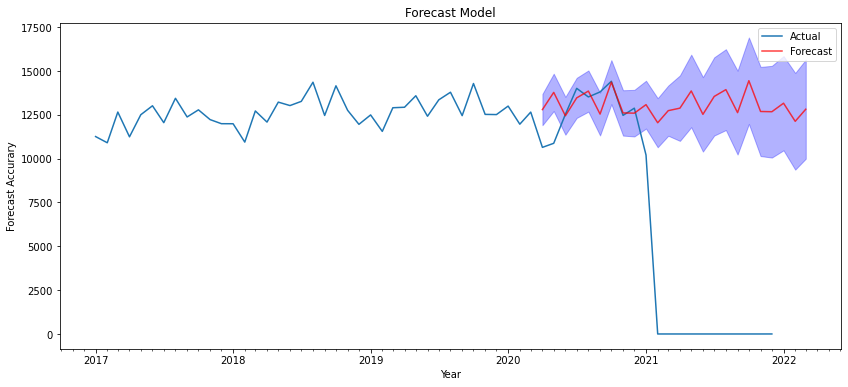

In [56]:
tsfm.back_testing_plot("HOME")

In [14]:
df

,Unnamed: 0,beg_month,product,region,district,terr,ro
0,0,2017-01-01,ACUTE,A1,R101,TMV1001,30
1,1,2017-01-01,ACUTE,A1,R101,TMV1002,31
2,2,2017-01-01,ACUTE,A1,R101,TMV1003,24
3,3,2017-01-01,ACUTE,A1,R101,TMV2001,37
4,4,2017-01-01,ACUTE,A1,R102,TMV1007,17
...,...,...,...,...,...,...,...
32720,32720,2021-01-01,HOME,A9,R906,TSV1142,30
32721,32721,2021-01-01,HOME,A9,R906,TSV1145,48
32722,32722,2021-01-01,HOME,A9,R906,TSV1147,67
32723,32723,2021-01-01,HOME,A9,R906,TSV1148,31


In [33]:
def test(a):
    return 1, None

In [34]:
a, b = test(1)

In [35]:
a

1